In [1]:
# Data Import
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

from pyriemann.classification import MDM
from pyriemann.estimation import ERPCovariances
from tqdm import tqdm

import sys
sys.path.append('./py.BI.EEG.2015b-GIPSA/')
from braininvaders2015b.dataset import BrainInvaders2015b

from scipy.io import loadmat
import numpy as np
import mne

import joblib
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
 
dataset = BrainInvaders2015b() # datapath="T:\Kaggle\BCIBachelorThesis\Data"

In [2]:
dataset.pair_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [3]:
scores = {}

largeRaws = []

for pair in dataset.pair_list[3:4]: # change this to change nr of pairs
    scores[pair] = {}

    print('pair', str(pair))
    sessions = dataset._get_single_pair_data(pair=pair)
    for session_name in sessions.keys():

        scores[pair][session_name] = {}

        raw = sessions[session_name]['run_1']
        largeRaws.append(raw)

pair 4


In [4]:
# 4 sessions per pair, 5 pairs = 20 recordings

## Data Inspection

In [5]:


raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1_1, FP2_1, AFz_1, F7_1, F3_1, F4_1, F8_1, FC5_1, FC1_1, ...
 chs: 64 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 512.0 Hz
>

['FP1_1',
  'FP2_1',
  'AFz_1',
  'F7_1',
  'F3_1',
  'F4_1',
  'F8_1',
  'FC5_1',
  'FC1_1',
  'FC2_1',
  'FC6_1',
  'T7_1',
  'C3_1',
  'Cz_1',
  'C4_1',
  'T8_1',
  'CP5_1',
  'CP1_1',
  'CP2_1',
  'CP6_1',
  'P7_1',
  'P3_1',
  'Pz_1',
  'P4_1',
  'P8_1',
  'PO7_1',
  'O1_1',
  'Oz_1',
  'O2_1',
  'PO8_1',
  'PO9_1',
  'PO10_1',
  'FP1_2',
  'FP2_2',
  'AFz_2',
  'F7_2',
  'F3_2',
  'F4_2',
  'F8_2',
  'FC5_2',
  'FC1_2',
  'FC2_2',
  'FC6_2',
  'T7_2',
  'C3_2',
  'Cz_2',
  'C4_2',
  'T8_2',
  'CP5_2',
  'CP1_2',
  'CP2_2',
  'CP6_2',
  'P7_2',
  'P3_2',
  'Pz_2',
  'P4_2',
  'P8_2',
  'PO7_2',
  'O1_2',
  'Oz_2',
  'O2_2',
  'PO8_2',
  'PO9_2',
  'PO10_2',
  'STI 014']

In [6]:
raw.info.ch_names, raw

(['FP1_1',
  'FP2_1',
  'AFz_1',
  'F7_1',
  'F3_1',
  'F4_1',
  'F8_1',
  'FC5_1',
  'FC1_1',
  'FC2_1',
  'FC6_1',
  'T7_1',
  'C3_1',
  'Cz_1',
  'C4_1',
  'T8_1',
  'CP5_1',
  'CP1_1',
  'CP2_1',
  'CP6_1',
  'P7_1',
  'P3_1',
  'Pz_1',
  'P4_1',
  'P8_1',
  'PO7_1',
  'O1_1',
  'Oz_1',
  'O2_1',
  'PO8_1',
  'PO9_1',
  'PO10_1',
  'FP1_2',
  'FP2_2',
  'AFz_2',
  'F7_2',
  'F3_2',
  'F4_2',
  'F8_2',
  'FC5_2',
  'FC1_2',
  'FC2_2',
  'FC6_2',
  'T7_2',
  'C3_2',
  'Cz_2',
  'C4_2',
  'T8_2',
  'CP5_2',
  'CP1_2',
  'CP2_2',
  'CP6_2',
  'P7_2',
  'P3_2',
  'Pz_2',
  'P4_2',
  'P8_2',
  'PO7_2',
  'O1_2',
  'Oz_2',
  'O2_2',
  'PO8_2',
  'PO9_2',
  'PO10_2',
  'STI 014'],
 <RawArray | 65 x 256288 (500.6 s), ~127.2 MB, data loaded>)

Before Filtering


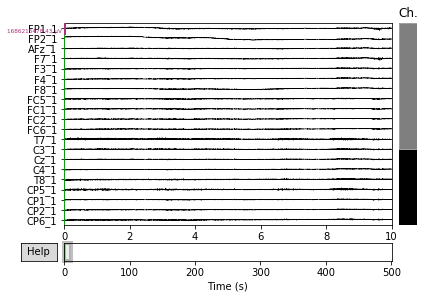

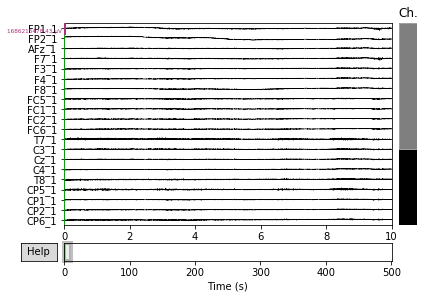

In [7]:
%matplotlib inline
# before filtering

# [63, 37, 28, 11, 29] <- from feature selection below
pick_channels = raw.ch_names[:32] #+ [raw.ch_names[-1]]   #0:32
raw_subject = raw.copy().pick_channels(pick_channels)

print("Before Filtering")
raw_subject.plot(scalings='auto')

In [8]:
saveMemory = True
if saveMemory:
    del dataset,raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1691 samples (3.303 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge:

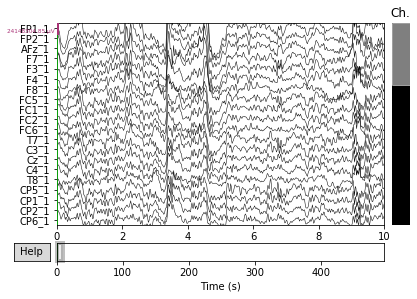

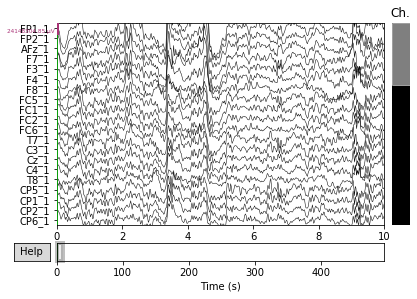

In [9]:
# After filteirng
for raw in largeRaws:
    fmin = 1
    fmax = 15
    raw.filter(fmin, fmax, verbose=True)   
#     raw.plot(scalings='auto')

largeRaws[0].plot(scalings="auto")

In [10]:
allEvents = []
for i,raw in enumerate(largeRaws):
    try:
        events = mne.find_events(raw) #  stim_channel='STI 014'
        allEvents.append(events)
    except ValueError as e:
        print(e)
        print("will skip trial no %d"%i)
# events

833 events found
Event IDs: [  1   2 100 102 104 106 107 108 109 110 111 160 161 163 164 165 180 182
 183 185]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 110 111 160 161 163 164 165 180 181
 182 183 184 185]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 112 160 161 162 163 164
 165 180 181 182 183]
833 events found
Event IDs: [  1   2 100 102 104 105 106 107 108 109 110 111 160 163 164 165 180 181
 182 183]


In [11]:
len(largeRaws),len(allEvents)

(4, 4)

In [12]:
allEpochs = []
from tqdm import tqdm
for raw,events in tqdm(zip(largeRaws,allEvents)):
    event_id = {'NonTarget': 1, 'Target': 2}
    tmin = 0.1  # start of each epoch 
    tmax = 0.5  # end of each epoch 
#     print(event_id)
    baseline = None  # means from the first instant to t = 0

    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                        baseline=baseline, preload=False)
#     print(epochs)
    allEpochs.append(epochs)

# del largeRaws

0it [00:00, ?it/s]

660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
630 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
660 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


4it [00:00, 129.03it/s]


In [13]:
len(allEvents),len(allEpochs)

(4, 4)

<Evoked  |  'NonTarget' (average, N=540), [0.099609, 0.5] sec, 64 ch, ~229 kB>


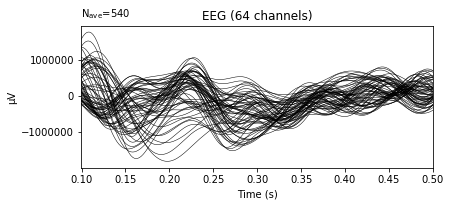

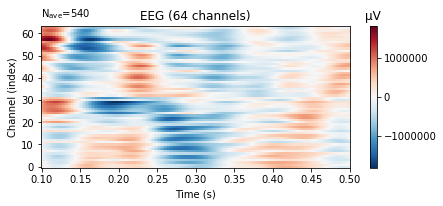

<Evoked  |  'Target' (average, N=120), [0.099609, 0.5] sec, 64 ch, ~229 kB>


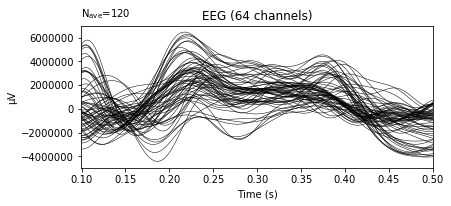

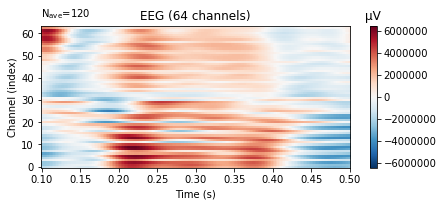

In [14]:
avg_nontargets = epochs['NonTarget'].average()
avg_targets = epochs['Target'].average()

classes = ["NonTarget","Target"]
subepochs = []

for cl in classes:
    evoked =  epochs[cl]
    print(evoked.average())
    subepochs.append(evoked)
    evoked.average().plot(window_title=cl)#scalings="auto"
    evoked.average().plot_image()#scalings="auto"

## Feature Selection

In [15]:
avg_nontargets_data = avg_nontargets.data
avg_targets_data = avg_targets.data

# split data to one subject only
avg_nontargets_data_s1 = np.zeros((int(avg_nontargets_data.shape[0]/2),avg_nontargets_data.shape[1]))
avg_targets_data_s1 = np.zeros((int(avg_nontargets_data.shape[0]/2),avg_nontargets_data.shape[1]))
ch_names = []

for i in range(avg_nontargets_data.shape[0]):
    # only every channel that ends with "_1" == first subject
    if "_1" in avg_nontargets.info.ch_names[i]:
        avg_nontargets_data_s1[i] = avg_nontargets_data[i]
        avg_targets_data_s1[i] = avg_targets_data[i]
        ch_names.append(avg_nontargets.info.ch_names[i])
print(avg_nontargets_data.shape,avg_targets_data.shape,avg_nontargets_data_s1.shape)

# X = np.concatenate([avg_nontargets_data,avg_targets_data],axis=0)
# y = np.concatenate([np.zeros(avg_nontargets_data.shape[0]),np.ones(avg_targets_data.shape[0])])

# X.shape,y.shape

(64, 206) (64, 206) (32, 206)


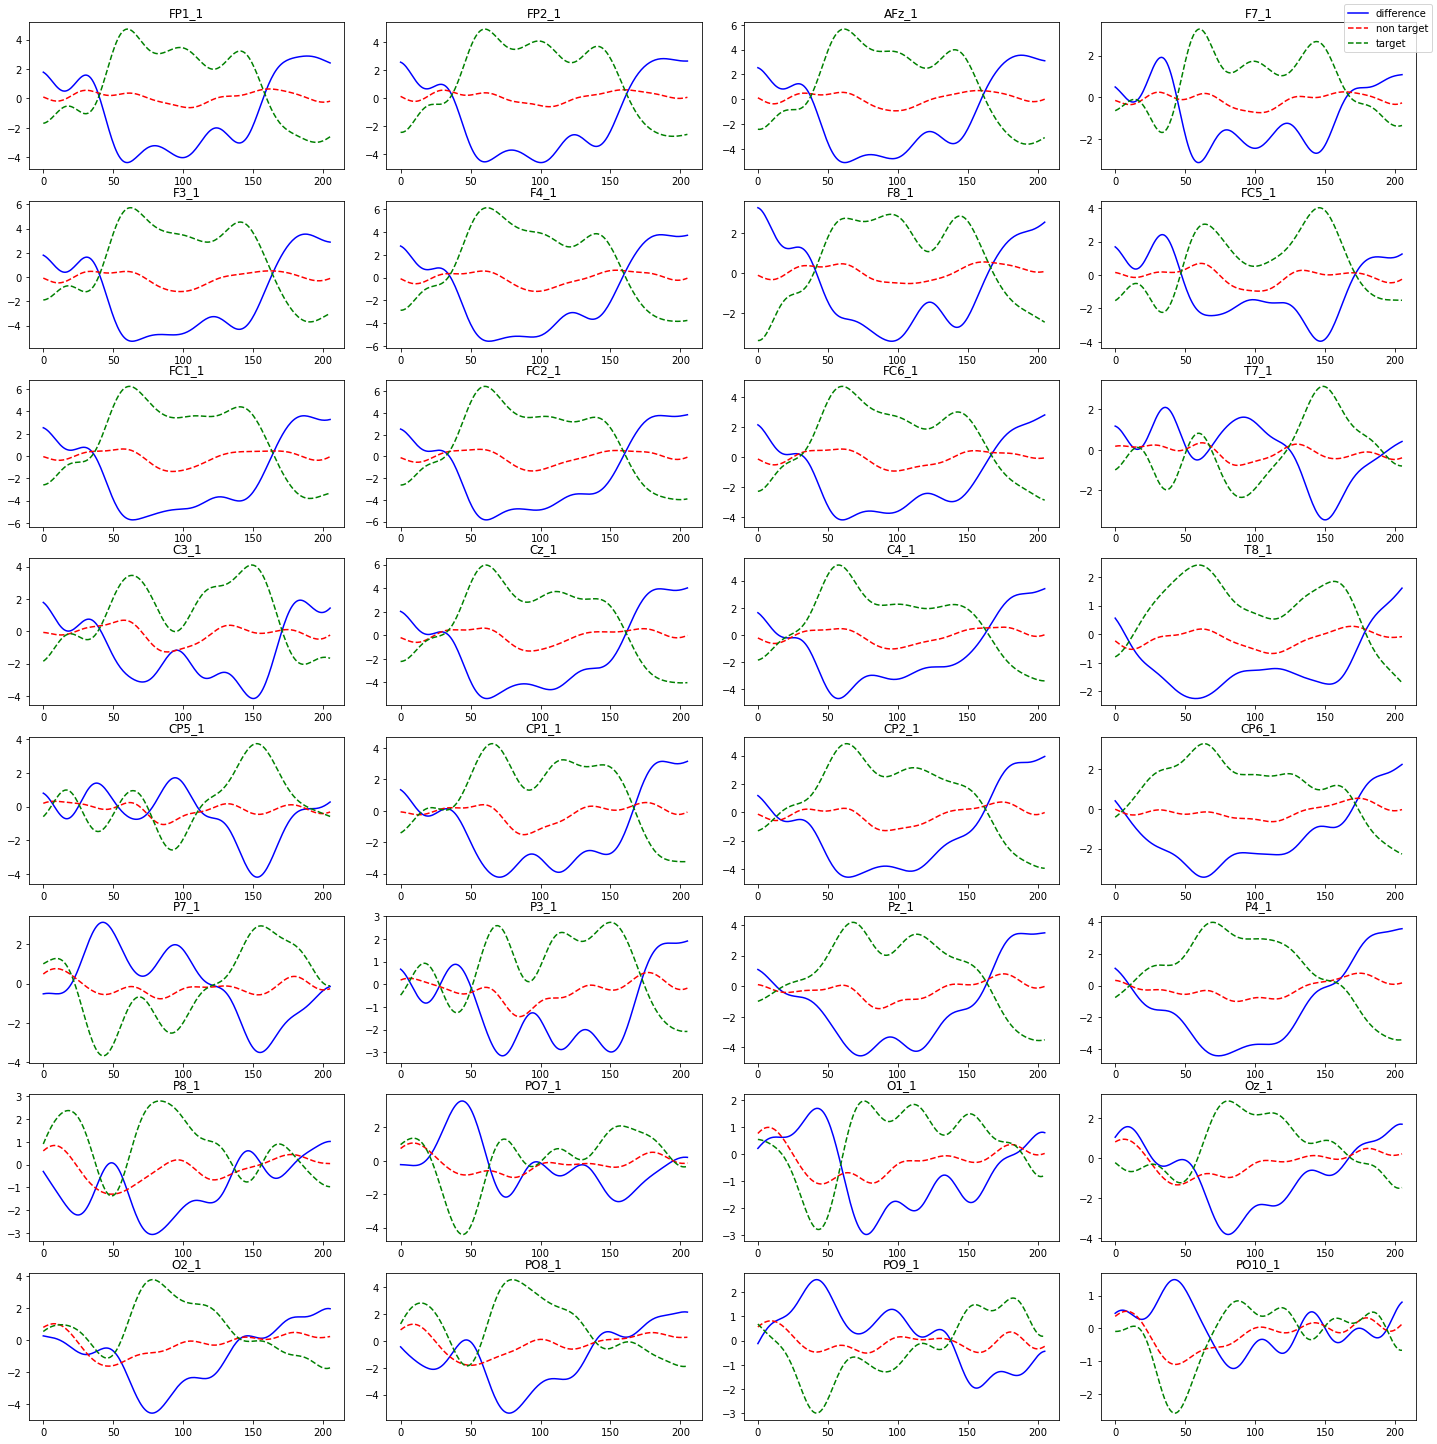

In [16]:
fig, axs = plt.subplots(8, 4,figsize=(20,20))
fig.tight_layout()
diffs = []
variances = []

for ch_nontarget, ch_target in zip(avg_nontargets_data_s1,avg_targets_data_s1):
    diff = ch_nontarget - ch_target
    diffs.append(diff)
    variances.append(np.var(diff))

cnt = 0 

for i in range(8):
    for j in range(4):
            axs[i,j].plot(diffs[cnt],'b',label="difference")
            axs[i,j].plot(avg_nontargets_data_s1[cnt],'r--',label="non target")
            axs[i,j].plot(avg_targets_data_s1[cnt],'g--',label="target")
            axs[i,j].title.set_text(ch_names[cnt])
            cnt += 1        
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

Text(0.5, 1.0, 'Variances of the differences of the channels')

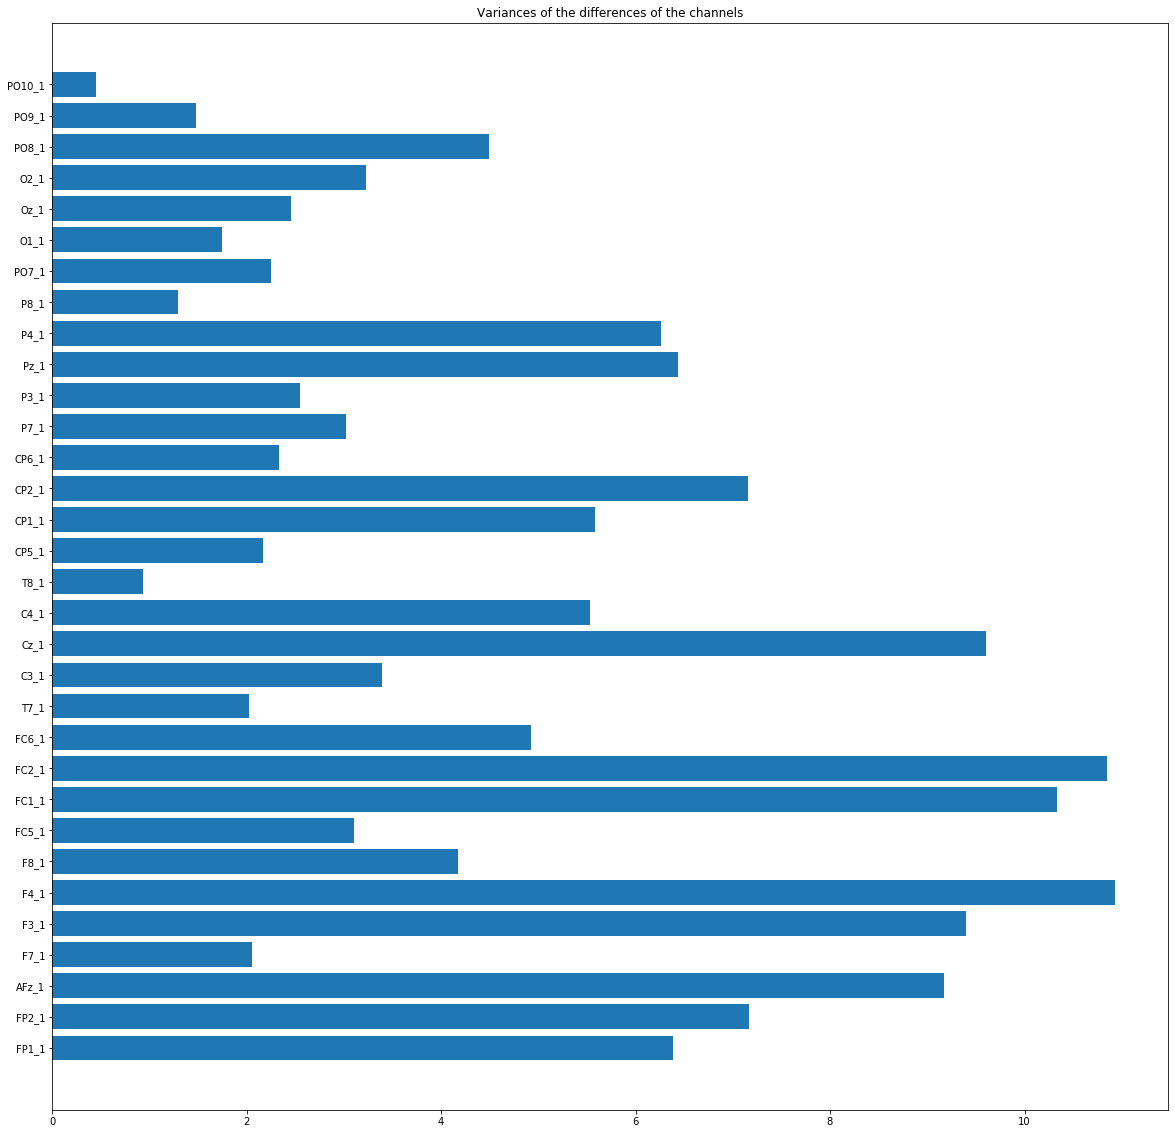

In [17]:
plt.rcParams["figure.figsize"] = (20,20)
plt.barh(ch_names,variances)
plt.title("Variances of the differences of the channels")



In [18]:
# find the most important channels, always test one


X = allEpochs[1].get_data()[:,:32,:]
y = allEpochs[1].events[:,-1]
y = y - 1  

# select only first subject

# # split data to one subject only
# X_s1 = np.zeros((X.shape[0],int(X.shape[1]/2),X.shape[2]))
# ch_names = []

# for i in range(X.shape[0]):
#     for j in range(X_s1.shape[1]):
#         # only every channel that ends with "_1" == first subject
#         cnt = 0
#         if "_1" in avg_nontargets.info.ch_names[j]:
#             try:
#                 X_s1[i,cnt] = X[i,j]
#             except IndexError as e:
#                 pass
#                 # should work except last
#             cnt += 1
#             ch_names.append(avg_nontargets.info.ch_names[j])
X.shape,y.shape

    
# print(X_s1[0])

Loading data for 630 events and 206 original time points ...
0 bad epochs dropped


((630, 32, 206), (630,))

In [19]:
ch_names = avg_nontargets.info.ch_names

In [20]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42,shuffle=True) # Xxdawn, ally


# do we have an imbalance?
distr = np.unique(y_train,return_counts=True)
print(distr)
ratio = distr[1][0]/distr[1][1]
print(ratio)
# yes! use class weights to fight this effect
targetsOnly = x_train[y_train==1.]
targetsOnly = np.repeat(targetsOnly,int(ratio)-1,axis=0) # upsample undersampled target array, minus one bc we already have that one set

nradds = len(targetsOnly)
print("upsampled %d trials"%nradds)

x_train = np.concatenate([x_train,targetsOnly])
y_train = np.concatenate([y_train,np.ones(nradds)],axis=0)
distr = np.unique(y_train,return_counts=True)
print(distr)
ratio = distr[1][0]/distr[1][1]
print("new ratio",ratio)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), y_train,classes=[0, 1])
print("class weights used: ",class_weights)


# del allX,ally # memory

x_train.shape,y_train.shape
print(x_train.shape,np.mean(x_train))


(array([0, 1], dtype=int64), array([345,  77], dtype=int64))
4.48051948051948
upsampled 231 trials
(array([0., 1.]), array([345, 308], dtype=int64))
new ratio 1.12012987012987
class weights used:  [0.94637681 1.06006494]
(653, 32, 206) 0.3760681297790242


T:\Anaconda\envs\bci\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0

# Try different filters

In [48]:
# for visualization
target = x_train[y_train==1.]
non_target = x_train[y_train==0.]

y_target = [1.] * len(target)
y_non_target = [0.] * len(non_target)

## PCA

Target
Non-Target


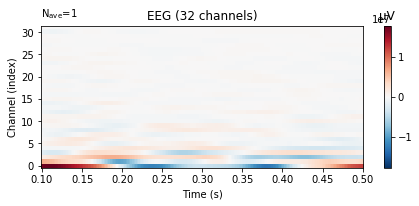

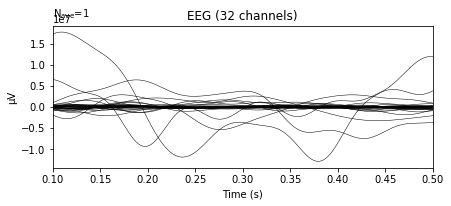

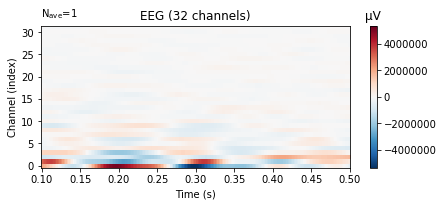

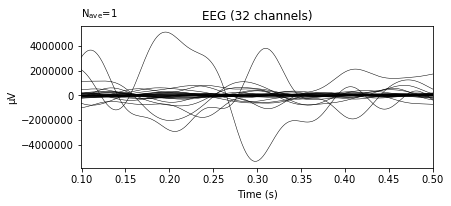

In [49]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

NO_CHANNELS = 32

print("Target")
pca = UnsupervisedSpatialFilter(PCA(NO_CHANNELS), average=False)
pca_data = pca.fit_transform(target)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(NO_CHANNELS, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot_image(show=False, time_unit='s')
ev.plot(show=False, time_unit='s')

print("Non-Target")
pca = UnsupervisedSpatialFilter(PCA(NO_CHANNELS), average=False)
pca_data = pca.fit_transform(non_target)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(NO_CHANNELS, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot_image(show=False, time_unit='s')
ev.plot(show=False, time_unit='s')


# for later feature elimination
pca = UnsupervisedSpatialFilter(PCA(NO_CHANNELS), average=False)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

## ICA

Target
Non-Target


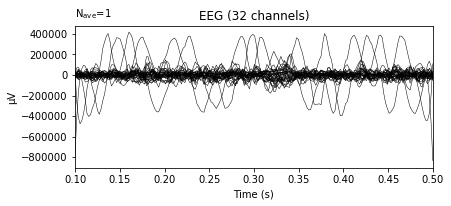

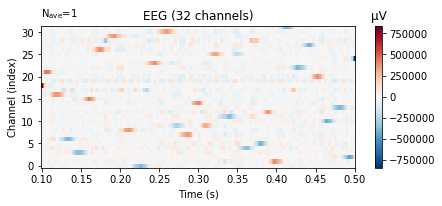

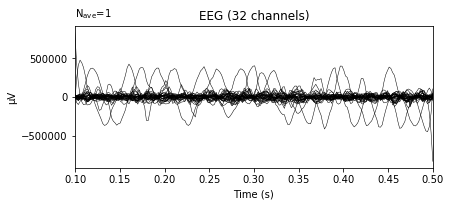

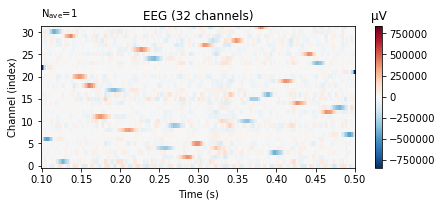

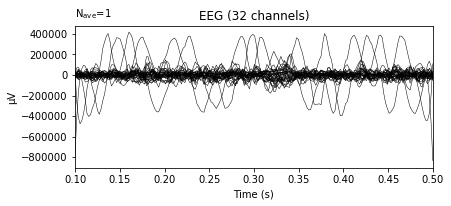

In [50]:

NO_CHANNELS = 32

print("Target")
ica = UnsupervisedSpatialFilter(FastICA(NO_CHANNELS), average=True)
ica_data = ica.fit_transform(pca_data)
ev = mne.EvokedArray(np.mean(ica_data, axis=0),
                     mne.create_info(NO_CHANNELS, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot_image(show=False, time_unit='s')
ev.plot(show=False, time_unit='s')

print("Non-Target")
ica = UnsupervisedSpatialFilter(FastICA(NO_CHANNELS), average=True)
ica_data = ica.fit_transform(pca_data)
ev = mne.EvokedArray(np.mean(ica_data, axis=0),
                     mne.create_info(NO_CHANNELS, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot_image(show=False, time_unit='s')
ev.plot(show=False, time_unit='s')

## pyriemann filteirng

In [51]:
# # scaling
# from mne.decoding import Scaler
# # get trials and labels
# # X = epochs.get_data()
# # y = epochs.events[:,-1]
# # y = y - 1  
# # print(X.shape,y.shape)
# # scaling

# scaler = Scaler(scalings="mean")
# Xscaled = scaler.fit_transform(allX,ally)

(308, 32, 206)
TARGET


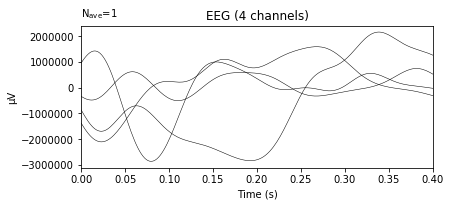

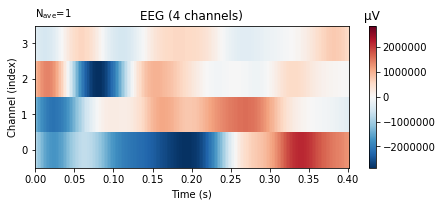

(308, 4, 206)
NON_TARGET


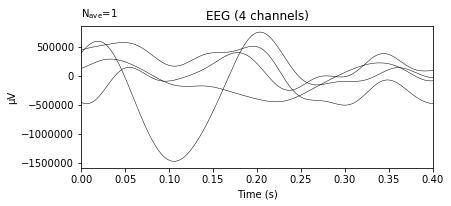

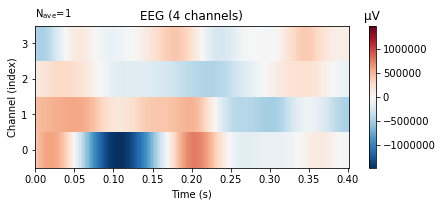

(345, 4, 206)


In [52]:
from pyriemann.spatialfilters import *
print(target.shape)

print("TARGET")
xdawn = Xdawn()
Xxdawn = xdawn.fit_transform(target,y_target)
Xxdawn.shape
ev = mne.EvokedArray(np.mean(Xxdawn, axis=0),mne.create_info(Xxdawn.shape[1], epochs.info['sfreq'],
                                      ch_types='eeg'))

ev.plot()
ev.plot_image()
print(Xxdawn.shape)


print("NON_TARGET")
xdawn = Xdawn()
Xxdawn = xdawn.fit_transform(non_target,y_non_target)
Xxdawn.shape
ev = mne.EvokedArray(np.mean(Xxdawn, axis=0),mne.create_info(Xxdawn.shape[1], epochs.info['sfreq'],
                                      ch_types='eeg'))

ev.plot()
ev.plot_image()
print(Xxdawn.shape)

# for later feature elimination
xdawn = Xdawn()
x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
x_test_XDAWN = xdawn.transform(x_test)

## recursive feature elimination

In [53]:
np.unique(y_test,return_counts=True)

(array([0, 1], dtype=int64), array([165,  43], dtype=int64))

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from pyriemann.estimation import *
from pyriemann.tangentspace import TangentSpace


plt.rcParams["figure.figsize"] = (5,5)
class_names = ["Non Target","Target"]

svc = SVC(kernel='linear')
covest = Covariances(estimator='lwf')
ts = TangentSpace()

clf = make_pipeline(covest,ts,svc)
# cross validation
clf.fit(x_train,y_train)

scr = cross_val_score(clf, x_train,y_train, cv=4)
print("Training score: ",scr.mean())
pred = clf.predict(x_test)


cr = classification_report(y_test,pred,target_names=class_names)
print(cr)

plot_confusion_matrix(clf,x_test,y_test,cmap=plt.cm.Blues,display_labels=class_names)
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [94]:
scores = []
for i in tqdm(range(x_train.shape[1])): # for every channel
    crnt_train = x_train.copy()
    crnt_train[:,i,:] = 0
    crnt_test = x_test.copy()
    crnt_test[:,i,:] = 0
    # new classifier 
    svc = SVC(kernel='linear')
    covest = Covariances(estimator='lwf')
    ts = TangentSpace()
    
    clf = make_pipeline(covest,ts,svc)
    clf.fit(crnt_train,y_train)
    
    scr = clf.score(crnt_test,y_test)
    scores.append(scr)

print(scores)

  6%|██████▋                                                                                                   | 2/32 [00:43<10:52, 21.76s/it]


KeyboardInterrupt: 

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)

min = np.min(scores)-0.001
max = np.max(scores)+0.001

plt.barh(ch_names[:32],scores)
plt.xlim([min,max])
plt.axvline(x=0.64,color="r",label="Baseline Score")
plt.title("Leave-One-Out Performance of each channel")
plt.legend()

In [ ]:
# the channels sorted according to score
srted_channels = [x for _,x in sorted(zip(scores,ch_names[:32]))]
srted_channels

In [ ]:

scoress = []
combinations = []

for i in tqdm(range(1,33)):
    keep_channels =  srted_channels[:i] #np.array(["T8_1","FC6_1","P4_1"])
    keep_channels_idx = []
    for ch in keep_channels:
        idx = np.where(np.array(ch_names[:32])==ch)[0][0]
        keep_channels_idx.append(idx)


    x_train_mod = x_train[:,keep_channels_idx,:]
    x_test_mod = x_test[:,keep_channels_idx,:]

    x_train_mod.shape,x_test_mod.shape

    # repeat classification with selected channels
    svc = SVC(kernel='linear')
    covest = Covariances(estimator='lwf')
    ts = TangentSpace()

    clf = make_pipeline(covest,ts,svc)
    # cross validation
    clf.fit(x_train_mod,y_train)

#     scr = cross_val_score(clf, x_train_mod,y_train, cv=4)
#     print("Training score: ",scr.mean())
#     pred = clf.predict(x_test_mod)

#     cr = classification_report(y_test,pred,target_names=class_names)
    print("Report for: ",keep_channels)
#     print(cr)
    scr = clf.score(x_test_mod,y_test)
    print(scr)
    scoress.append(scr)
    combinations.append(keep_channels)
# plot_confusion_matrix(clf,x_test_mod,y_test,cmap=plt.cm.Blues,display_labels=class_names)
# plt.show()

In [55]:
best = ['T8_1',
   'FC6_1',
   'P4_1',
   'C4_1',
   'CP2_1',
   'F8_1',
   'FP2_1',
   'FP1_1',
   'P8_1',
   'PO8_1',
   'FC2_1',
   'P3_1',
   'P7_1',
   'PO10_1',
   'PO9_1',
   'CP1_1',
   'FC1_1',
   'O2_1',
   'PO7_1',
   'CP5_1']

In [ ]:
worst = ['T8_1', 'FC6_1', 'P4_1', 'C4_1', 'CP2_1', 'F8_1']
len(['T8_1', 'FC6_1', 'P4_1', 'C4_1', 'CP2_1', 'F8_1'])

In [56]:
srted_combis = [x for _,x in sorted(zip(scoress,combinations))]
srted_combis_len = [len(x) for _,x in sorted(zip(scoress,combinations))]


plt.bar(srted_combis_len,scoress)
plt.axhline(y=.64,color="r")
plt.xlabel("Channel Combinations according to Figure 17")
plt.ylabel("Accuracy Score")

srted_combis, sorted(scoress)

NameError: name 'scoress' is not defined

In [57]:
keep_channels =  best
keep_channels_idx = []
for ch in keep_channels:
    idx = np.where(np.array(ch_names[:32])==ch)[0][0]
    keep_channels_idx.append(idx)


x_train_mod = x_train[:,keep_channels_idx,:]
x_test_mod = x_test[:,keep_channels_idx,:]

x_train_mod.shape,x_test_mod.shape

# repeat classification with selected channels
svc = SVC(kernel='linear')
covest = Covariances(estimator='lwf')
ts = TangentSpace()

clf = make_pipeline(covest,ts,svc)
# cross validation
clf.fit(x_train_mod,y_train)

#     scr = cross_val_score(clf, x_train_mod,y_train, cv=4)
#     print("Training score: ",scr.mean())
pred = clf.predict(x_test_mod)

cr = classification_report(y_test,pred,target_names=class_names)
print("Report for: ",keep_channels)
print(cr)


NameError: name 'Covariances' is not defined

## PCA feature elimination

In [62]:
from pyriemann.estimation import *


#x_train_pca,x_test_pca defined above
svc = SVC(kernel='linear')
covest = Covariances(estimator='lwf')
ts = TangentSpace()

clf = make_pipeline(covest,ts,svc)
# cross validation
clf.fit(x_train_pca,y_train)

#     scr = cross_val_score(clf, x_train_mod,y_train, cv=4)
#     print("Training score: ",scr.mean())
pred = clf.predict(x_test_pca)

cr = classification_report(y_test,pred,target_names=class_names)
print("Report for: PCA")
print(cr)


Report for: PCA
              precision    recall  f1-score   support

  Non Target       0.79      0.75      0.77       165
      Target       0.20      0.23      0.21        43

    accuracy                           0.64       208
   macro avg       0.49      0.49      0.49       208
weighted avg       0.67      0.64      0.65       208



## XDAWN feature elimination

In [63]:
# x_train_XDAWN,x_test_XDAWN defined above

svc = SVC(kernel='linear')
covest = Covariances(estimator='lwf')
ts = TangentSpace()

clf = make_pipeline(covest,ts,svc)
# cross validation
clf.fit(x_train_XDAWN,y_train)


pred = clf.predict(x_test_XDAWN)

cr = classification_report(y_test,pred,target_names=class_names)
print("Report for: PCA")
print(cr)


Report for: PCA
              precision    recall  f1-score   support

  Non Target       0.85      0.75      0.80       165
      Target       0.34      0.49      0.40        43

    accuracy                           0.70       208
   macro avg       0.59      0.62      0.60       208
weighted avg       0.74      0.70      0.72       208



# trainings

In [22]:
from pyriemann.estimation import *

covobj = Covariances(estimator='lwf')
cov_train = covobj.fit_transform(x_train_mod)
# cross validation
mdm = MDM(n_jobs=-1)

accuracy = cross_val_score(mdm, cov_train, y_train)

print("Train avg score: ", accuracy.mean())

# test
cov_test = covobj.transform(x_test_mod)
accuracy = cross_val_score(mdm, cov_test, y_test)

print("Test avg score: ",accuracy.mean())


NameError: name 'x_train_mod' is not defined

In [65]:
 # cross validation
skf = StratifiedKFold(n_splits=2)

clf1 = make_pipeline(ERPCovariances(estimator='lwf', classes=[1]), MDM(n_jobs=-1))
clf1.fit(x_train_mod,y_train)

scr = cross_val_score(clf1, x_test_mod, y_test, cv=skf, scoring = 'accuracy').mean()
print("Score avg test: ",scr)

Score avg test:  0.8509615384615384


In [66]:
 # cross validation
skf = StratifiedKFold(n_splits=2)

clf1 = make_pipeline(XdawnCovariances(estimator='lwf', classes=[1]), MDM(n_jobs=-1))
clf1.fit(x_train_mod,y_train)

scr = cross_val_score(clf1, x_test_mod, y_test, cv=skf, scoring = 'accuracy').mean()
print("Score avg test: ",scr)

Score avg test:  0.8701923076923077


## trying out all variations

In [153]:

x_comb = [[x_train_mod,x_test_mod],[x_train_XDAWN,x_test_XDAWN]]
opt_comb = [Covariances(estimator='lwf'),ERPCovariances(estimator='lwf'),XdawnCovariances(estimator='lwf'),CospCovariances(),HankelCovariances(estimator="lwf") ]
class_comb = [MDM(n_jobs=-1),SVC(kernel='linear')]
ts = TangentSpace()
x_comb_names =["Recursive Ft. Elim.","XDAWN"]
opt_comb_names = ["Covariances","ERPCovariances","XdawnCovariances","CospCovariances"]
class_comb_names = ["MDM","SVC"]

scores = []
scores_n = []

for x,xn in tqdm(zip(x_comb,x_comb_names),total=len(x_comb)):
    for opt,optn in zip(opt_comb,opt_comb_names):
        for clf,clfn in zip(class_comb,class_comb_names):
#             ts = TangentSpace()
            try:
                if clfn == "SVC":
                    ts = TangentSpace()
                    clf1 = make_pipeline(opt,ts,clf)
                else:
                    clf1 = make_pipeline(opt,clf)
                x_train,x_test = x
                clf1.fit(x_train,y_train)
                scr = cross_val_score(clf1, x_test, y_test, cv=4, scoring = 'accuracy').mean()
                print("score: %.3f - %s"%(scr," ".join([xn,optn,clfn])))
                scores.append(scr)
                scores_n.append(" ".join([xn,optn,clfn]))
            except ValueError as e:
                print(e, "Skip!",optn,clfn,xn)


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]

score: 0.673 - Recursive Ft. Elim. Covariances MDM
score: 0.697 - Recursive Ft. Elim. Covariances SVC
score: 0.812 - Recursive Ft. Elim. ERPCovariances MDM
score: 0.875 - Recursive Ft. Elim. ERPCovariances SVC
score: 0.817 - Recursive Ft. Elim. XdawnCovariances MDM
score: 0.822 - Recursive Ft. Elim. XdawnCovariances SVC
too many values to unpack (expected 3) Skip! CospCovariances MDM Recursive Ft. Elim.


 50%|█████████████████████████████████████████████████████▌                                                     | 1/2 [00:29<00:29, 29.70s/it]

Shape must be of len 2 or 3. Skip! CospCovariances SVC Recursive Ft. Elim.
score: 0.673 - XDAWN Covariances MDM
score: 0.755 - XDAWN Covariances SVC
score: 0.923 - XDAWN ERPCovariances MDM
score: 0.885 - XDAWN ERPCovariances SVC
score: 0.904 - XDAWN XdawnCovariances MDM
score: 0.880 - XDAWN XdawnCovariances SVC
too many values to unpack (expected 3) Skip! CospCovariances MDM XDAWN


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:46<00:00, 23.01s/it]

Shape must be of len 2 or 3. Skip! CospCovariances SVC XDAWN


# final lstm training

### LSTM

In [116]:
xdcov = Covariances(estimator='lwf')
x_train_dawnedcov = xdcov.fit_transform(x_train_mod,y_train)
x_test_dawnedcov = xdcov.transform(x_test_mod)

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model = Sequential()
model.add(LSTM(units = 50, return_sequences = False, input_shape = (x_train_dawnedcov.shape[1], x_train_dawnedcov.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 15, return_sequences = False))
# model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                14200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
redlr = ReduceLROnPlateau(monitor='val_accuracy',patience=20)
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=500)

hist = model.fit(x_train_dawnedcov,y_train,batch_size=64, validation_data=(x_test_dawnedcov,y_test),epochs=2000,callbacks=[es,redlr], class_weight= class_weights)

#val_acc pure X = 0.8257
# xdawn = 0.8486
# xscaled = 0.8165
# xscaled & xdawn = 0.8165
# pcadata = 0,8165
# icadata = 0,8211

# all channels xdawn - 0,8670

Train on 653 samples, validate on 208 samples
Epoch 1/2000
653/653 [==============================] - 1s 1ms/sample - loss: 0.7391 - accuracy: 0.5145 - val_loss: 0.6478 - val_accuracy: 0.6346
Epoch 2/2000
653/653 [==============================] - 0s 86us/sample - loss: 0.6573 - accuracy: 0.6141 - val_loss: 0.6044 - val_accuracy: 0.7067
Epoch 3/2000
653/653 [==============================] - 0s 106us/sample - loss: 0.6473 - accuracy: 0.6325 - val_loss: 0.6123 - val_accuracy: 0.6875
Epoch 4/2000
653/653 [==============================] - 0s 100us/sample - loss: 0.6210 - accuracy: 0.6753 - val_loss: 0.6228 - val_accuracy: 0.6394
Epoch 5/2000
653/653 [==============================] - 0s 107us/sample - loss: 0.6136 - accuracy: 0.6830 - val_loss: 0.5986 - val_accuracy: 0.7067
Epoch 6/2000
653/653 [==============================] - 0s 107us/sample - loss: 0.6014 - accuracy: 0.6861 - val_loss: 0.6038 - val_accuracy: 0.7019
Epoch 7/2000
653/653 [==============================] - 0s 118us/samp

653/653 [==============================] - 0s 107us/sample - loss: 0.1222 - accuracy: 0.9724 - val_loss: 0.7853 - val_accuracy: 0.7115
Epoch 57/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.1155 - accuracy: 0.9862 - val_loss: 0.7794 - val_accuracy: 0.6779
Epoch 58/2000
653/653 [==============================] - 0s 90us/sample - loss: 0.1167 - accuracy: 0.9694 - val_loss: 0.7862 - val_accuracy: 0.6875
Epoch 59/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.1216 - accuracy: 0.9755 - val_loss: 0.7897 - val_accuracy: 0.7260
Epoch 60/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.1210 - accuracy: 0.9632 - val_loss: 0.7184 - val_accuracy: 0.7260
Epoch 61/2000
653/653 [==============================] - 0s 98us/sample - loss: 0.1120 - accuracy: 0.9694 - val_loss: 0.7942 - val_accuracy: 0.7260
Epoch 62/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.0974 - accuracy: 0.9740 - val_loss: 0.8030 

653/653 [==============================] - 0s 92us/sample - loss: 0.0644 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 167/2000
653/653 [==============================] - 0s 95us/sample - loss: 0.0630 - accuracy: 0.9985 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 168/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0625 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 169/2000
653/653 [==============================] - 0s 90us/sample - loss: 0.0747 - accuracy: 0.9832 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 170/2000
653/653 [==============================] - 0s 89us/sample - loss: 0.0660 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 171/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0665 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 172/2000
653/653 [==============================] - 0s 86us/sample - loss: 0.0663 - accuracy: 0.9954 - val_loss: 0.

653/653 [==============================] - 0s 90us/sample - loss: 0.0653 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 222/2000
653/653 [==============================] - 0s 86us/sample - loss: 0.0658 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 223/2000
653/653 [==============================] - 0s 90us/sample - loss: 0.0665 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 224/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0657 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 225/2000
653/653 [==============================] - 0s 86us/sample - loss: 0.0695 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 226/2000
653/653 [==============================] - 0s 90us/sample - loss: 0.0630 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 227/2000
653/653 [==============================] - 0s 89us/sample - loss: 0.0674 - accuracy: 0.9908 - val_loss: 0.

653/653 [==============================] - 0s 92us/sample - loss: 0.0683 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 277/2000
653/653 [==============================] - 0s 113us/sample - loss: 0.0676 - accuracy: 0.9862 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 278/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.0652 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 279/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0729 - accuracy: 0.9877 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 280/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.0637 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 281/2000
653/653 [==============================] - 0s 98us/sample - loss: 0.0659 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 282/2000
653/653 [==============================] - 0s 90us/sample - loss: 0.0702 - accuracy: 0.9908 - val_loss: 0

653/653 [==============================] - 0s 98us/sample - loss: 0.0655 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 332/2000
653/653 [==============================] - 0s 97us/sample - loss: 0.0712 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 333/2000
653/653 [==============================] - 0s 95us/sample - loss: 0.0647 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 334/2000
653/653 [==============================] - 0s 89us/sample - loss: 0.0666 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 335/2000
653/653 [==============================] - 0s 95us/sample - loss: 0.0640 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 336/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0674 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 337/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0668 - accuracy: 0.9893 - val_loss: 0.

653/653 [==============================] - 0s 89us/sample - loss: 0.0647 - accuracy: 0.9954 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 387/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.0665 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 388/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0666 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 389/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0759 - accuracy: 0.9816 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 390/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0632 - accuracy: 0.9969 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 391/2000
653/653 [==============================] - 0s 95us/sample - loss: 0.0663 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 392/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.0669 - accuracy: 0.9893 - val_loss: 0.

653/653 [==============================] - 0s 95us/sample - loss: 0.0652 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 442/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.0707 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 443/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0689 - accuracy: 0.9893 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 444/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0706 - accuracy: 0.9877 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 445/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.0626 - accuracy: 0.9969 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 446/2000
653/653 [==============================] - 0s 96us/sample - loss: 0.0633 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 447/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.0630 - accuracy: 0.9969 - val_loss: 0.

653/653 [==============================] - 0s 95us/sample - loss: 0.0712 - accuracy: 0.9862 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 497/2000
653/653 [==============================] - 0s 93us/sample - loss: 0.0663 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 498/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0632 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 499/2000
653/653 [==============================] - 0s 89us/sample - loss: 0.0659 - accuracy: 0.9939 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 500/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0680 - accuracy: 0.9908 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 501/2000
653/653 [==============================] - 0s 87us/sample - loss: 0.0691 - accuracy: 0.9923 - val_loss: 0.8759 - val_accuracy: 0.7212
Epoch 502/2000
653/653 [==============================] - 0s 92us/sample - loss: 0.0619 - accuracy: 0.9969 - val_loss: 0.

In [78]:
print ( "mean : %.3f "%np.mean(hist.history["val_accuracy"]))

# mean : 0.851 

mean : 0.812 


# repeat feature selection

In [23]:
from sklearn.model_selection import GridSearchCV


xdawn = Xdawn()
x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
x_test_XDAWN = xdawn.transform(x_test)
###
mdm_param = [ 'riemann' , 'logeuclid' , 'euclid' , 'logdet', 'wasserstein']
erpcov_param = ["lwf","oas","scm"]

scrs = []
combs = []
for mp in tqdm(mdm_param):
    for ep in erpcov_param:
        try:
            mdm = MDM(n_jobs=-1,metric=mp)
            covest = ERPCovariances(estimator=ep)
            clf = make_pipeline(covest,mdm)
            clf.fit(x_train_XDAWN,y_train)
            scr = cross_val_score(clf, x_test_XDAWN, y_test, cv=4, scoring = 'accuracy').mean()
#             scr = clf.score(x_test_XDAWN, y_test)
        except:
            scr = 0.
        print(scr)
        scrs.append(scr)
        combs.append("-".join([mp,ep]))

print(scrs,combs)

  0%|                                                                                                                   | 0/5 [00:00<?, ?it/s]

0.9230769230769231
0.9134615384615384


 20%|█████████████████████▍                                                                                     | 1/5 [00:15<01:00, 15.24s/it]

0.9086538461538463
0.9182692307692308
0.8990384615384615


 40%|██████████████████████████████████████████▊                                                                | 2/5 [00:16<00:33, 11.03s/it]

0.7355769230769231
0.8317307692307692
0.8317307692307692


 60%|████████████████████████████████████████████████████████████████▏                                          | 3/5 [00:17<00:15,  8.00s/it]

0.841346153846154
0.9326923076923077
0.9134615384615385


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4/5 [00:20<00:06,  6.53s/it]

0.9278846153846154
0.8461538461538463
0.8413461538461539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.76s/it]

0.0
[0.9230769230769231, 0.9134615384615384, 0.9086538461538463, 0.9182692307692308, 0.8990384615384615, 0.7355769230769231, 0.8317307692307692, 0.8317307692307692, 0.841346153846154, 0.9326923076923077, 0.9134615384615385, 0.9278846153846154, 0.8461538461538463, 0.8413461538461539, 0.0] ['riemann-lwf', 'riemann-oas', 'riemann-scm', 'logeuclid-lwf', 'logeuclid-oas', 'logeuclid-scm', 'euclid-lwf', 'euclid-oas', 'euclid-scm', 'logdet-lwf', 'logdet-oas', 'logdet-scm', 'wasserstein-lwf', 'wasserstein-oas', 'wasserstein-scm']


In [27]:
len([0.9230769230769231, 0.9134615384615384, 0.9086538461538463, 0.9182692307692308, 0.8990384615384615, 0.7355769230769231, 0.8317307692307692, 0.8317307692307692, 0.841346153846154, 0.9326923076923077, 0.9134615384615385, 0.9278846153846154, 0.8461538461538463, 0.8413461538461539, 0.0])

15

In [28]:
# the channels sorted according to score
srted_combs = [x for y,x in sorted(zip(scrs,combs))]
srted_combs
srted_scrs = sorted(scrs)
srted_combs,srted_scrs

(['wasserstein-scm',
  'logeuclid-scm',
  'euclid-lwf',
  'euclid-oas',
  'wasserstein-oas',
  'euclid-scm',
  'wasserstein-lwf',
  'logeuclid-oas',
  'riemann-scm',
  'riemann-oas',
  'logdet-oas',
  'logeuclid-lwf',
  'riemann-lwf',
  'logdet-scm',
  'logdet-lwf'],
 [0.0,
  0.7355769230769231,
  0.8317307692307692,
  0.8317307692307692,
  0.8413461538461539,
  0.841346153846154,
  0.8461538461538463,
  0.8990384615384615,
  0.9086538461538463,
  0.9134615384615384,
  0.9134615384615385,
  0.9182692307692308,
  0.9230769230769231,
  0.9278846153846154,
  0.9326923076923077])

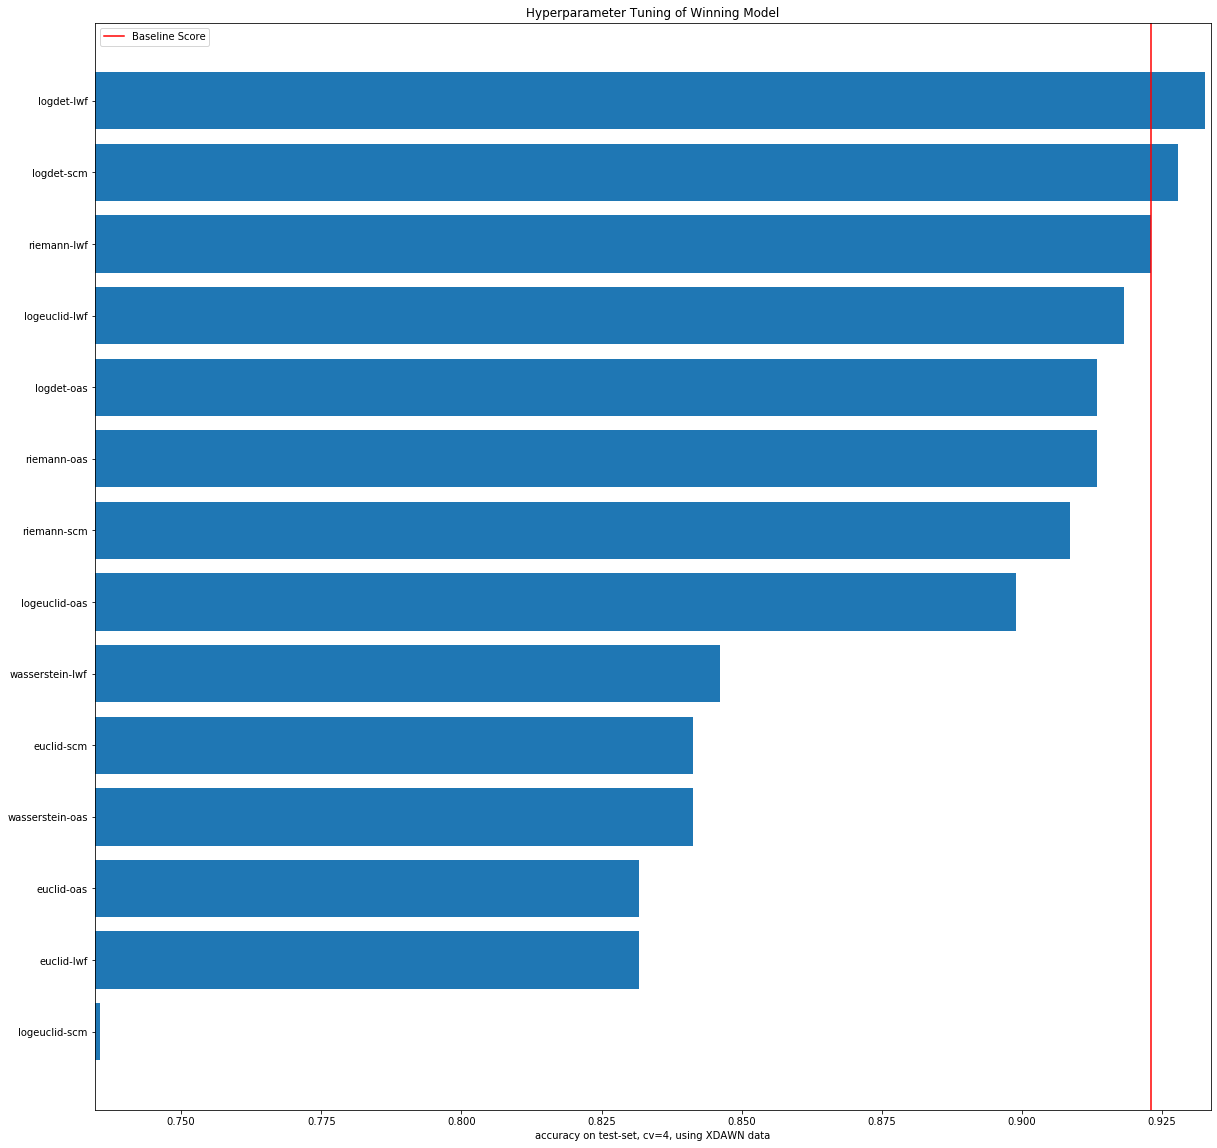

In [35]:
plt.rcParams["figure.figsize"] = (20,20)

min = np.min(srted_scrs[1:])-0.001
max = np.max(scrs)+0.001

plt.barh(srted_combs[1:],srted_scrs[1:])
plt.xlim([min,max])
plt.axvline(x=0.923,color="r",label="Baseline Score")
plt.title("Hyperparameter Tuning of Winning Model")
plt.xlabel("accuracy on test-set, cv=4, using XDAWN data")
plt.legend()

## final model classification report


Report for winning model:
              precision    recall  f1-score   support

  Non-Target       0.94      0.94      0.94       165
      Target       0.77      0.77      0.77        43

    accuracy                           0.90       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.90      0.90      0.90       208



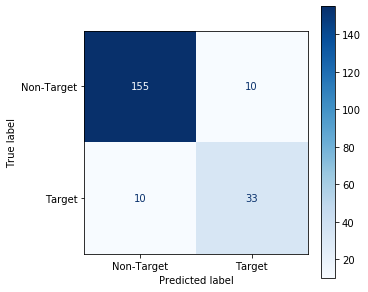

In [29]:
from pyriemann.estimation import ERPCovariances
from pyriemann.spatialfilters import Xdawn
from pyriemann.classification import MDM

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix


xdawn = Xdawn()
x_train_XDAWN = xdawn.fit_transform(x_train,y_train)
x_test_XDAWN = xdawn.transform(x_test)

mdm = MDM(n_jobs=-1, metric = "logdet")
covest = ERPCovariances(estimator="lwf")
clf = make_pipeline(covest,mdm)

clf.fit(x_train_XDAWN,y_train)

pred = clf.predict(x_test_XDAWN)

class_names = ["Non-Target","Target"]
cr = classification_report(y_test,pred,target_names=class_names)
print("Report for winning model:")
print(cr)

plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(clf,x_test_XDAWN,y_test,cmap=plt.cm.Blues,display_labels=class_names)
plt.show()